# Цель лабораторной работы
Изучить линейные модели, SVM и деревья решений.<cite data-cite="ue:lab5"></cite>.

# Задание
Требуется выполнить следующие действия<cite data-cite="ue:lab5"></cite>:

1. Выбрать набор данных (датасет) для решения задачи классификации или регрессии.
2. В случае необходимости провести удаление или заполнение пропусков и кодирование категориальных признаков.
3. С использованием метода `train_test_split` разделить выборку на обучающую и тестовую.
3. Обучить следующие модели:
    - одну из линейных моделей;
    - SVM;
    - дерево решений.
4. Оценить качество моделей с помощью трех подходящих для задачи метрик. Сравнить качество полученных моделей.
5. Произвести для каждой модели подбор одного гиперпараметра с использованием GridSearchCV и кросс-валидации.
6. Повторить пункт 4 для найденных оптимальных значений гиперпараметров. Сравните качество полученных моделей с качеством моделей, полученных в пункте 4.

# Дополнительные задания

1. Провести эксперименты с важностью признаков в дереве решений.
2. Визуализировать дерево решений.

# Ход выполнения работы

Подключим все необходимые библиотеки и настроим отображение графиков<cite data-cite="doc:ipython,doc:seaborn"></cite>:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import graphviz
import pydotplus
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from operator import itemgetter

# Enable inline plots
%matplotlib inline

# Set plots formats to save high resolution PNG
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

os.environ["PATH"] += os.pathsep
os.environ["PATH"] += 'C:/Program Files (x86)/Graphviz2.38/bin/'

Зададим ширину текстового представления данных, чтобы в дальнейшем текст в отчёте влезал на А4<cite data-cite="doc:pandas"></cite>:

In [2]:
pd.set_option("display.width", 70)

## Предварительная подготовка данных

В качестве набора данных будем использовать датасет с ценами поддержанных машин в Индии<cite data-cite="kg:ucpi"></cite>:

In [3]:
data = pd.read_csv("./used_cars.csv")

Посмотрим на типы данных:

In [4]:
data.dtypes

Index                  int64
Name                  object
Location              object
Year                   int64
Kilometers_Driven      int64
Fuel_Type             object
Transmission          object
Owner_Type            object
Mileage              float64
Engine               float64
Power                float64
Seats                float64
New_Price             object
Price                float64
dtype: object

Посмотрим на данные:

In [5]:
data.head(10)

,Index,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,8.61,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,NaN,17.74
5,5,Hyundai EON LPG Era Plus Option,Hyderabad,2012,75000,LPG,Manual,First,21.10,814.0,55.20,5.0,NaN,2.35
6,6,Nissan Micra Diesel XV,Jaipur,2013,86999,Diesel,Manual,First,23.08,1461.0,63.10,5.0,NaN,3.50
7,7,Toyota Innova Crysta 2.8 GX AT 8S,Mumbai,2016,36000,Diesel,Automatic,First,11.36,2755.0,171.50,8.0,21,17.50
8,8,Volkswagen Vento Diesel Comfortline,Pune,2013,64430,Diesel,Manual,First,20.54,1598.0,103.60,5.0,NaN,5.20
9,9,Tata Indica Vista Quadrajet LS,Chennai,2012,65932,Diesel,Manual,Second,22.30,1248.0,74.00,5.0,NaN,1.95


Удалим ненужные столбцы:

In [6]:
data = data.drop(["Index", "Name", "Location", "New_Price"], axis=1)

Выполним кодирование категориальных признаков:

In [7]:
le = LabelEncoder()
data[["Fuel_Type"]] = le.fit_transform(
    data[["Fuel_Type"]].values.ravel())

data[["Transmission"]] = le.fit_transform(
    data[["Transmission"]].values.ravel())

data[["Owner_Type"]] = le.fit_transform(
    data[["Owner_Type"]].values.ravel())

Проверим данные на наличие пропусков:

In [8]:
data.isnull().sum()

Year                   0
Kilometers_Driven      0
Fuel_Type              0
Transmission           0
Owner_Type             0
Mileage                2
Engine                36
Power                143
Seats                 42
Price                  0
dtype: int64

Заполним пропуски медианным значением:

In [9]:
median_imp = SimpleImputer(strategy="median") 
data[["Mileage"]] =  median_imp.fit_transform(data[["Mileage"]])
data[["Engine"]] = median_imp.fit_transform(data[["Engine"]])
data[["Power"]] = median_imp.fit_transform(data[["Power"]])
data[["Seats"]] = median_imp.fit_transform(data[["Seats"]])

In [10]:
data.isnull().sum()

Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Engine               0
Power                0
Seats                0
Price                0
dtype: int64

Посмотрим на новые типы данных:

In [11]:
data.dtypes

Year                   int64
Kilometers_Driven      int64
Fuel_Type              int32
Transmission           int32
Owner_Type             int32
Mileage              float64
Engine               float64
Power                float64
Seats                float64
Price                float64
dtype: object

In [12]:
data.head(10)

,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,2010,72000,0,1,0,26.60,998.0,58.16,5.0,1.75
1,2015,41000,1,1,0,19.67,1582.0,126.20,5.0,12.50
2,2011,46000,4,1,0,18.20,1199.0,88.70,5.0,4.50
3,2012,87000,1,1,0,20.77,1248.0,88.76,7.0,6.00
4,2013,40670,1,0,2,15.20,1968.0,140.80,5.0,17.74
5,2012,75000,3,1,0,21.10,814.0,55.20,5.0,2.35
6,2013,86999,1,1,0,23.08,1461.0,63.10,5.0,3.50
7,2016,36000,1,0,0,11.36,2755.0,171.50,8.0,17.50
8,2013,64430,1,1,0,20.54,1598.0,103.60,5.0,5.20
9,2012,65932,1,1,2,22.30,1248.0,74.00,5.0,1.95


Посмотрим на размер данных:

In [13]:
data.shape

(6019, 10)

Посмотрим на основные статистические характеристики набора данных:

In [14]:
data.describe()

,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
count,6019.000000,6.019000e+03,6019.000000,6019.000000,6019.000000,6019.000000,6019.000000,6019.000000,6019.000000,6019.000000
mean,2013.358199,5.873838e+04,2.363017,0.714238,0.379465,18.134966,1620.509221,112.883539,5.276790,9.479468
std,3.269742,9.126884e+04,1.504939,0.451814,0.818458,4.581528,599.635458,53.283701,0.806346,11.187917
min,1998.000000,1.710000e+02,0.000000,0.000000,0.000000,0.000000,72.000000,34.200000,0.000000,0.440000
25%,2011.000000,3.400000e+04,1.000000,0.000000,0.000000,15.170000,1198.000000,78.000000,5.000000,3.500000
50%,2014.000000,5.300000e+04,1.000000,1.000000,0.000000,18.150000,1493.000000,97.700000,5.000000,5.640000
75%,2016.000000,7.300000e+04,4.000000,1.000000,0.000000,21.100000,1969.000000,138.030000,5.000000,9.950000
max,2019.000000,6.500000e+06,4.000000,1.000000,3.000000,33.540000,5998.000000,560.000000,10.000000,160.000000


## Разделение данных
Разделим данные на целевой столбец и признаки:

In [15]:
x = data.drop("Price", axis=1)
y = data["Price"]

In [16]:
x.head()

,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats
0,2010,72000,0,1,0,26.60,998.0,58.16,5.0
1,2015,41000,1,1,0,19.67,1582.0,126.20,5.0
2,2011,46000,4,1,0,18.20,1199.0,88.70,5.0
3,2012,87000,1,1,0,20.77,1248.0,88.76,7.0
4,2013,40670,1,0,2,15.20,1968.0,140.80,5.0


In [17]:
y.head()

0     1.75
1    12.50
2     4.50
3     6.00
4    17.74
Name: Price, dtype: float64

Обработаем данные, чтобы модель была более точной:

In [18]:
columns = x.columns
scaler = StandardScaler()
x = scaler.fit_transform(x)

Разделим выборку на обучающую и тестовую<cite data-cite="doc:sklearn"></cite>:

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.25,
                                                    random_state=77)

In [20]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(4514, 9) (1505, 9) (4514,) (1505,)


## Обучение моделей

Напишем функцию, которая считает метрики построенной модели:

In [21]:
def test_model(model, x_test, y_test):
    print("r2_score:", r2_score(y_test, model.predict(x_test)))
    print("mean_squared_error:",
          mean_squared_error(y_test, model.predict(x_test)))
    print("median_absolute_error:",
          median_absolute_error(y_test, model.predict(x_test)))

### Ridge регрессия

Ridge регрессия с гиперпараметром $\alpha=0,5$:

In [22]:
rdg = Ridge(alpha=0.5)
rdg.fit(x_train, y_train)

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [23]:
test_model(rdg, x_test, y_test)

r2_score: 0.7138082242771551
mean_squared_error: 35.35932893183665
median_absolute_error: 2.4329131305844856


Получили довольно неплохие оценки

### SVM

SVR с гиперпараметром $C=0,5$:

In [24]:
svm = SVR(C=3.0, gamma='scale')
svm.fit(x_train, y_train)

SVR(C=3.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [25]:
test_model(svm, x_test, y_test)

r2_score: 0.8270730067432199
mean_squared_error: 21.36533246043204
median_absolute_error: 0.8421629782693447


Как мы видим, SVR справился с задачей лучше Ridge регрессии

### Дерево решений

Дерево решений с глубиной дерева $max\_depth=2$:

In [26]:
dtr = DecisionTreeRegressor(max_depth=2)
dtr.fit(x_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [27]:
test_model(dtr, x_test, y_test)

r2_score: 0.6361926334480652
mean_squared_error: 44.94882604241194
median_absolute_error: 2.162802527646128


Данная модель показала наихудший результат по сравнению с другими моделям, хотя при этом довольно приемлимый

## Подбор гиперпараметра с испльзованием GridSearchCV и кросс-валидациии

### Ridge регрессия

Создадим список настраиваемых параметров:

In [28]:
param_range = np.arange(0, 20.0, 0.1)
grid_params = [{'alpha': param_range}]
grid_params

[{'alpha': array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
          1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
          2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
          3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
          4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
          5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
          6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
          7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
          8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
          9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9,
         11. , 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12. ,
         12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13. , 13.1,
         13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14. , 14.1, 14.2,
         14.3, 1

Начнем подбор параметра:

In [29]:
gs = GridSearchCV(Ridge(), grid_params,
                  cv=ShuffleSplit(n_splits=5), n_jobs=-1,
                  scoring="r2", return_train_score=True)
gs.fit(x, y)
gs.best_params_

{'alpha': 19.900000000000002}

In [30]:
gs.best_estimator_

Ridge(alpha=19.900000000000002, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

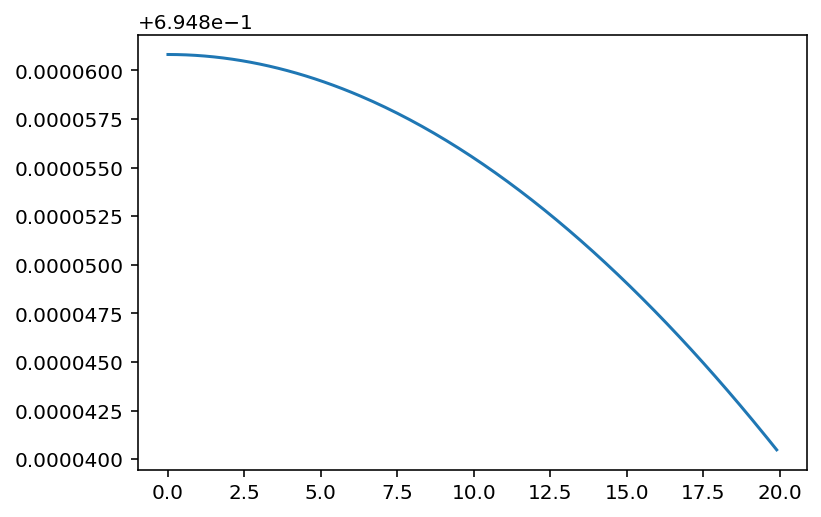

In [31]:
plt.plot(param_range, gs.cv_results_["mean_train_score"]);

Получили довльно странный результат. Проблема скорее всего в том, что данный метод не может дать хороший результат для данной выборки

### SVM

Создадим список настраиваемых параметров:

In [32]:
param_range = np.arange(0.1, 10.0, 0.5)
grid_params = [{'C': param_range}]
grid_params

[{'C': array([0.1, 0.6, 1.1, 1.6, 2.1, 2.6, 3.1, 3.6, 4.1, 4.6, 5.1, 5.6, 6.1,
         6.6, 7.1, 7.6, 8.1, 8.6, 9.1, 9.6])}]

Начнем подбор параметра:

In [33]:
gs = GridSearchCV(SVR(gamma='scale'), grid_params,
                  cv=ShuffleSplit(n_splits=5), n_jobs=-1,
                  scoring="r2", return_train_score=True)
gs.fit(x, y)
gs.best_params_

{'C': 9.6}

In [34]:
gs.best_estimator_

SVR(C=9.6, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

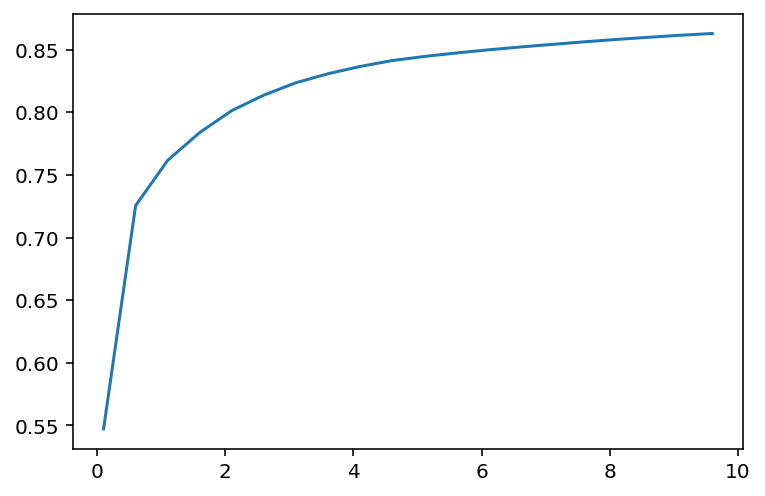

In [35]:
plt.plot(param_range, gs.cv_results_["mean_train_score"]);

Обучим модель с использованием подобранного параметра:

In [36]:
svm = SVR(C=gs.best_params_['C'], gamma='scale')
svm.fit(x_train, y_train)

SVR(C=9.6, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [37]:
test_model(svm, x_test, y_test)

r2_score: 0.8497236791026992
mean_squared_error: 18.566815373547925
median_absolute_error: 0.7989548385844407


Как мы видим, модель дала лишь небольшое улучшение с подобранным параметром

### Дерево решений

Создадим список настраиваемых параметров:

In [38]:
param_range = np.arange(1, 50, 1)
grid_params = [{'max_depth': param_range}]
grid_params

[{'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
         35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])}]

Начнем подбор параметра:

In [39]:
gs = GridSearchCV(DecisionTreeRegressor(), grid_params,
                  cv=ShuffleSplit(n_splits=5), n_jobs=-1,
                  scoring="r2", return_train_score=True)
gs.fit(x, y)
gs.best_estimator_

DecisionTreeRegressor(criterion='mse', max_depth=12, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

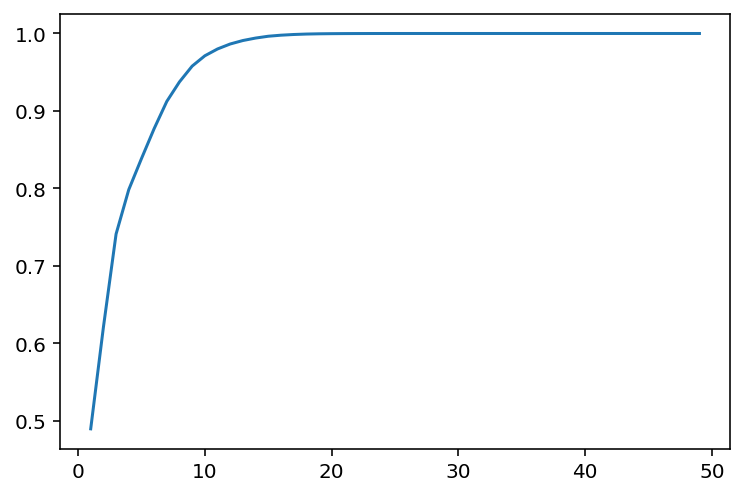

In [40]:
plt.plot(param_range, gs.cv_results_["mean_train_score"]);

Обучим модель с использованием подобранного параметра:

In [41]:
dtr = DecisionTreeRegressor(max_depth=gs.best_params_['max_depth'])
dtr.fit(x_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=12, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [42]:
test_model(dtr, x_test, y_test)

r2_score: 0.8428690731973061
mean_squared_error: 19.413709957764162
median_absolute_error: 0.7999999999999998


Как мы видим, модель показала значительное улучшение с подобранным параметром

## Эксперименты с важностью признаков в дереве решений

С помощью свойства `featureimportances` можно получить значение важности признаков. Вычисление важности признаков основано на том, какое количество раз признак встречается в условиях дерева. Чем чаще встречается признак, тем более он важен.

Важность признаков:

In [43]:
list(zip(columns.values, dtr.feature_importances_))

[('Year', 0.16909165392593634),
 ('Kilometers_Driven', 0.05590702023106376),
 ('Fuel_Type', 0.004773484145493002),
 ('Transmission', 0.008511197372427367),
 ('Owner_Type', 0.0019495498271238686),
 ('Mileage', 0.02361097958034725),
 ('Engine', 0.06544323097344992),
 ('Power', 0.6559494235304008),
 ('Seats', 0.014763460413757683)]

Важность признаков в сумме дает единицу:

In [44]:
sum(dtr.feature_importances_)

0.9999999999999999

Напишем функцию для вывода важности признаков в виде графика:

In [45]:
def draw_feature_importances(tree_model, columns, figsize=(15,7)):
    # Сортировка значений важности признаков по убыванию
    list_to_sort = list(zip(columns.values, tree_model.feature_importances_))
    sorted_list = sorted(list_to_sort, key=itemgetter(1), reverse = True)
    # Названия признаков
    labels = [x for x,_ in sorted_list]
    # Важности признаков
    data = [x for _,x in sorted_list]
    # Вывод графика
    fig, ax = plt.subplots(figsize=figsize)
    ind = np.arange(len(labels))
    plt.bar(ind, data)
    plt.xticks(ind, labels, rotation='vertical')
    # Вывод значений
    for a,b in zip(ind, data):
        plt.text(a-0.05, b+0.01, str(round(b,3)))
    plt.show()
    return labels, data

И вывыдем график:

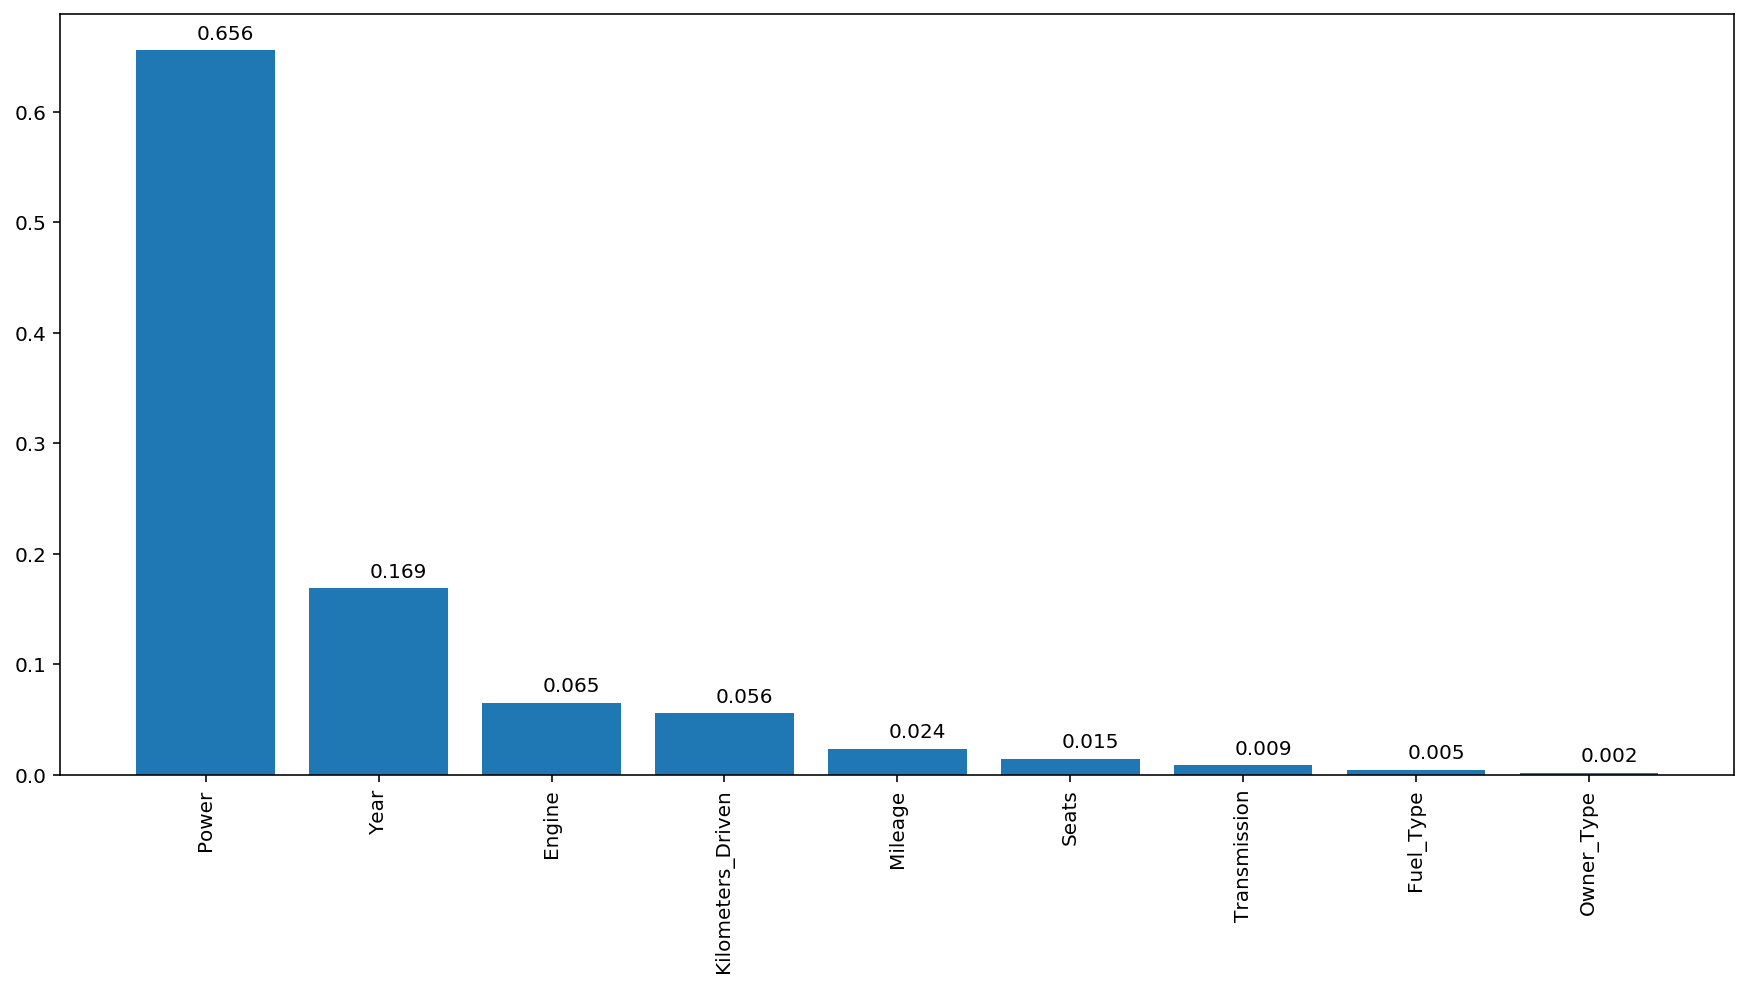

In [46]:
dtr_fl, dtr_fd = draw_feature_importances(dtr, columns)

Список признаков, отсортированный на основе важности, и значения важности:

In [47]:
dtr_fl, dtr_fd

(['Power',
  'Year',
  'Engine',
  'Kilometers_Driven',
  'Mileage',
  'Seats',
  'Transmission',
  'Fuel_Type',
  'Owner_Type'],
 [0.6559494235304008,
  0.16909165392593634,
  0.06544323097344992,
  0.05590702023106376,
  0.02361097958034725,
  0.014763460413757683,
  0.008511197372427367,
  0.004773484145493002,
  0.0019495498271238686])

Обучим дерево и предскажем результаты на всех признаках:

In [48]:
dtr_exp = DecisionTreeRegressor(max_depth=gs.best_params_['max_depth'])
dtr_exp.fit(x_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=12, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

Проверим точность:

In [49]:
test_model(dtr_exp, x_test, y_test)

r2_score: 0.843925961235849
mean_squared_error: 19.283130203316027
median_absolute_error: 0.7923529411764711


Обучим дерево и предскажем результаты на единственном самом важном признаке:

In [50]:
feature_index = [index for index, column in enumerate(columns)
                 if column == dtr_fl[0]][0];
x_train_feature = [item[feature_index] for item in x_train];
x_train_feature = np.reshape(x_train_feature, (-1, 1));

In [51]:
dtr_exp = DecisionTreeRegressor(max_depth=gs.best_params_['max_depth'])
dtr_exp.fit(x_train_feature, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=12, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

Проверим точность:

In [52]:
x_test_feature = [item[feature_index] for item in x_test];
x_test_feature = np.reshape(x_test_feature, (-1, 1));

In [53]:
test_model(dtr_exp, x_test_feature, y_test)

r2_score: 0.777127537760558
mean_squared_error: 27.536153623801386
median_absolute_error: 1.1764062500000008


Как мы видим, использование одного, но важного признака, дает неплохие результаты на тестах

## Визуализация дерева решений

In [54]:
dot_data = export_graphviz(dtr, out_file=None, feature_names=columns,
                rounded=True, filled=True, special_characters=True);
pydot_graph = pydotplus.graph_from_dot_data(dot_data);
pydot_graph.write_png('tree.jpg');

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.254744 to fit



![](tree.jpg)